In [1]:
# %% Cell 1: Gerekli Kütüphaneler ve Ayarlar
import os
import cv2
import random
import joblib
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from func_timeout import func_timeout, FunctionTimedOut
from skimage.feature import hog

# Cihaz ayarı (GPU varsa GPU, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
import os
import shutil
import random

# Kök klasör
base_dir = "C:/Users/Tuna/Downloads/images"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Sınıflar (örneğin: happy, sad, etc.)
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Test klasörünü oluştur
for cls in classes:
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

for cls in classes:
    print(f"\n▶️ {cls} sınıfı için örnekler hazırlanıyor...")

    # Tüm resimleri topla
    train_cls_path = os.path.join(train_dir, cls)
    val_cls_path = os.path.join(val_dir, cls)

    all_images = []

    for folder in [train_cls_path, val_cls_path]:
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_images += [(os.path.join(folder, f), f) for f in files]

    # Karıştır
    random.shuffle(all_images)

    total_count = len(all_images)
    test_count = int(0.2 * total_count)

    print(f"Toplam: {total_count} -> Test'e ayrılacak: {test_count} görsel")

    # Test için seçilen görselleri yeni klasöre kopyala
    selected_test_images = all_images[:test_count]
    for src_path, filename in selected_test_images:
        dst_path = os.path.join(test_dir, cls, filename)
        shutil.copy2(src_path, dst_path)

    print(f"✅ {cls}: Test seti tamamlandı. ({len(selected_test_images)} resim)")

print("\n🎉 Tüm sınıflar için test seti başarıyla oluşturuldu!")



▶️ angry sınıfı için örnekler hazırlanıyor...
Toplam: 6699 -> Test'e ayrılacak: 1339 görsel
✅ angry: Test seti tamamlandı. (1339 resim)

▶️ fear sınıfı için örnekler hazırlanıyor...
Toplam: 5879 -> Test'e ayrılacak: 1175 görsel
✅ fear: Test seti tamamlandı. (1175 resim)

▶️ happy sınıfı için örnekler hazırlanıyor...
Toplam: 13915 -> Test'e ayrılacak: 2783 görsel
✅ happy: Test seti tamamlandı. (2783 resim)

▶️ neutral sınıfı için örnekler hazırlanıyor...
Toplam: 11509 -> Test'e ayrılacak: 2301 görsel
✅ neutral: Test seti tamamlandı. (2301 resim)

▶️ sad sınıfı için örnekler hazırlanıyor...
Toplam: 11234 -> Test'e ayrılacak: 2246 görsel
✅ sad: Test seti tamamlandı. (2246 resim)

▶️ surprise sınıfı için örnekler hazırlanıyor...
Toplam: 5642 -> Test'e ayrılacak: 1128 görsel
✅ surprise: Test seti tamamlandı. (1128 resim)

🎉 Tüm sınıflar için test seti başarıyla oluşturuldu!


In [3]:
# %% Cell 2: CNN Modeli Tanımlaması (DeepCNNFeatureExtractor)
# Bu model, 1 kanallı (grayscale) 64x64 görüntüler için sıfırdan eğitilecek şekilde tasarlanmıştır.
class DeepCNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(DeepCNNFeatureExtractor, self).__init__()
        # Blok 1: 1 -> 32 kanal
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64 -> 32x32

        # Blok 2: 32 -> 64 kanal
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16

        # Blok 3: 64 -> 128 kanal
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5   = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8

        # Tam bağlantılı katman: Özellik vektörü boyutu 128*8*8 = 8192'den 256'ya indirme
        self.fc = nn.Linear(128 * 8 * 8, 256)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        features = self.fc(x)  # 256 boyutlu özellik vektörü
        return features

# Örnek test (isteğe bağlı)
if __name__ == '__main__':
    dummy = torch.randn(1, 1, 64, 64).to(device)
    feat = DeepCNNFeatureExtractor().to(device)(dummy)
    print("CNN özellik vektörü boyutu:", feat.shape)  # Beklenen: [1, 256]


CNN özellik vektörü boyutu: torch.Size([1, 256])


In [4]:
# %% Cell 3: HOG Özellik Çıkarım Fonksiyonu
def extract_hog_features(image, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9):
    """
    image: Giriş görüntüsü (grayscale, numpy array, boyut: 64x64)
    HOG özellikleri çıkarılır.
    """
    # image'ı float formatına çeviriyoruz
    image = np.float32(image) / 255.0
    features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
    return features

# Örnek test
test_image = np.random.randint(0, 256, (64, 64), dtype=np.uint8)
hog_feat = extract_hog_features(test_image)
print("HOG özelliği boyutu:", hog_feat.shape)


HOG özelliği boyutu: (1764,)


In [5]:
# %% Cell 4: LPG Özellik Çıkarım Fonksiyonu (Sobel Gradyanları ile)
def extract_lpg_features(image):
    """
    image: Giriş görüntüsü (grayscale, numpy array, boyut: 64x64)
    Sobel gradyanları kullanılarak yön histogramı hesaplanır.
    """
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    angle = cv2.phase(grad_x, grad_y, angleInDegrees=True)
    hist = cv2.calcHist([np.uint8(angle)], [0], None, [36], [0, 360])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Örnek test
lpg_feat = extract_lpg_features(test_image)
print("LPG özelliği boyutu:", lpg_feat.shape)


LPG özelliği boyutu: (36,)


In [6]:
# %% Cell 5: Hibrit Özellik Çıkarım Fonksiyonu (CNN, HOG, LPG)
def extract_hybrid_features(image_tensor, cnn_model, original_image):
    """
    image_tensor: CNN için ön işlenmiş tensör (1x64x64)
    original_image: Orijinal veya yeniden boyutlandırılmış grayscale görüntü (64x64 numpy array)
    """
    # CNN özellikleri
    cnn_model.eval()
    with torch.no_grad():
        feat = cnn_model(image_tensor.unsqueeze(0).to(device))
        cnn_feat = feat.squeeze(0).cpu().numpy()  # Boyut: [256]

    hog_feat = extract_hog_features(original_image)  # Boyut: örneğin ~1764
    lpg_feat = extract_lpg_features(original_image)  # Boyut: [36]

    # Hibrit özellik vektörü: CNN + HOG + LPG
    hybrid_feat = np.concatenate([cnn_feat, hog_feat, lpg_feat])
    return hybrid_feat

# Örnek test
dummy_tensor = torch.randn(1, 64, 64)  # rastgele örnek (1x64x64)
hybrid_test = extract_hybrid_features(dummy_tensor, DeepCNNFeatureExtractor().to(device), test_image)
print("Hibrit özellik vektörü boyutu:", hybrid_test.shape)


Hibrit özellik vektörü boyutu: (2056,)


In [7]:
# %% Cell 6: Dataset Sınıfı ve Transform Ayarları

from torch.utils.data import Dataset
import os
import cv2
from PIL import Image
from torchvision import transforms

class EmotionDatasetFromSamples(Dataset):
    def __init__(self, samples, transform=None):
        """
        samples: [(img_path, label)] formatında örneklerin listesi
        transform: Resim için uygulanacak dönüşümler
        """
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # Orijinal görüntüyü cv2 ile oku ve yeniden boyutlandır
        original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if original_image is None:
            raise ValueError(f"Resim okunamadı: {img_path}")
        original_image = cv2.resize(original_image, (64, 64))
        # PIL ile açıp grayscale'e çevir
        image_pil = Image.open(img_path).convert("L")
        if self.transform:
            image_tensor = self.transform(image_pil)
        else:
            from torchvision.transforms import ToTensor
            image_tensor = ToTensor()(image_pil)
        return image_tensor, original_image, label
        
# Transform: Grayscale, Resize (64x64), ToTensor, Normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
# %% Cell 7: Hibrit Özellik Çıkarım Fonksiyonu ve Veri Yollarının Ayarlanması
def extract_hybrid_features_from_dataset(dataset, cnn_model):
    features_list, labels_list = [], []
    cnn_model.eval()
    with torch.no_grad():
        for idx, (img_tensor, original_image, label) in enumerate(dataset):
            feat = extract_hybrid_features(img_tensor, cnn_model, original_image)
            features_list.append(feat)
            labels_list.append(label)
            if idx % 100 == 0:
                print(f"{idx} örnek işlendi...")
    return np.array(features_list), np.array(labels_list)

In [9]:
import os
import shutil
import random

# Mevcut klasörler
base_dir = "C:/Users/Tuna/Downloads/images"
existing_splits = ["train", "validation", "test"]
temp_pool_dir = "C:/Users/Tuna/Downloads/images_all_temp"  # geçici havuz

# Geçici havuz klasörünü oluştur
os.makedirs(temp_pool_dir, exist_ok=True)

# Tüm verileri geçici havuza kopyala (var olan klasör yapısı korunmadan)
for split in existing_splits:
    split_dir = os.path.join(base_dir, split)
    classes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
    for cls in classes:
        class_path = os.path.join(split_dir, cls)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Geçici havuzda her sınıf için klasör oluştur
        temp_class_dir = os.path.join(temp_pool_dir, cls)
        os.makedirs(temp_class_dir, exist_ok=True)
        for img in images:
            src = os.path.join(class_path, img)
            dst = os.path.join(temp_class_dir, img)
            shutil.copy2(src, dst)

print("Tüm veriler geçici havuza kopyalandı:", temp_pool_dir)


Tüm veriler geçici havuza kopyalandı: C:/Users/Tuna/Downloads/images_all_temp


In [10]:
train_folder = "C:\\Users\\Tuna\\Downloads\\images_all_temp"  
all_samples = []

classes = sorted(os.listdir(train_folder))

from sklearn.model_selection import train_test_split

classes = sorted(os.listdir(train_folder))

for label, class_name in enumerate(classes):
    class_path = os.path.join(train_folder, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        if os.path.exists(img_path):
            all_samples.append((img_path, label))
        else:
            print("Eksik dosya:", img_path)
            
# Eğitim ve test verilerini ayır (60% eğitim, 40% test)
train_samples, test_samples = train_test_split(
    all_samples, test_size=0.4, stratify=[label for _, label in all_samples], random_state=42
)

# Doğrulama ve test verilerini ayır (20% + 20%)
val_samples, test_samples = train_test_split(
    test_samples, test_size=0.5, stratify=[label for _, label in test_samples], random_state=42
)


# Yeni datasetleri oluştur
train_dataset = EmotionDatasetFromSamples(train_samples, transform=transform)
val_dataset = EmotionDatasetFromSamples(val_samples, transform=transform)
test_dataset = EmotionDatasetFromSamples(test_samples, transform=transform)


# Dataloaders oluştur
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("Sınıflar:", classes)

Sınıflar: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [11]:
# Öznitelik Çıkarımı
import time
import joblib
import numpy as np
from func_timeout import func_timeout, FunctionTimedOut
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

# Parametre aralığını daraltılmış ve n_iter belirlenmiş parametre dağılımı
param_distributions = {
    'C': [0.1, 1],
    'gamma': [0.01, 0.1]
}

# SVM için temel fonksiyon
def base_svm(**kwargs):
    kwargs.setdefault('class_weight', 'balanced')
    return SVC(kernel="rbf", **kwargs)

# Hibrit özellik çıkarımı
print("Hibrit öznitelikler çıkarılıyor (CNN + HOG + LPG)...")

# Burada, tüm verinin yeniden bölünmüş datasetlerini (train, validation, test) kullanıyoruz.
# Bu datasetlerin, tüm veriyi bir havuzda toplayıp 60/20/20 oranında böldüğünüz bölümde oluşturduğunuzu varsayıyoruz.
X_train, y_train = extract_hybrid_features_from_dataset(train_dataset, DeepCNNFeatureExtractor().to(device))
X_val, y_val     = extract_hybrid_features_from_dataset(val_dataset, DeepCNNFeatureExtractor().to(device))
X_test, y_test   = extract_hybrid_features_from_dataset(test_dataset, DeepCNNFeatureExtractor().to(device))

print("Öznitelik çıkarımı tamamlandı.")
print("Train veri boyutu: ", X_train.shape)
print("Validation veri boyutu: ", X_val.shape)
print("Test veri boyutu: ", X_test.shape)

# PCA ile boyut indirgeme: Örneğin, orijinal özellik boyutunu 500'e indiriyoruz
pca = PCA(n_components=500, random_state=42)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced   = pca.transform(X_val)
X_test_reduced  = pca.transform(X_test)

print("PCA sonrası boyutlar:")
print("Train: ", X_train_reduced.shape)
print("Validation: ", X_val_reduced.shape)
print("Test: ", X_test_reduced.shape)

# PCA nesnesini kaydedelim
joblib.dump(pca, "pca_transformer.pkl")


Hibrit öznitelikler çıkarılıyor (CNN + HOG + LPG)...
0 örnek işlendi...
100 örnek işlendi...
200 örnek işlendi...
300 örnek işlendi...
400 örnek işlendi...
500 örnek işlendi...
600 örnek işlendi...
700 örnek işlendi...
800 örnek işlendi...
900 örnek işlendi...
1000 örnek işlendi...
1100 örnek işlendi...
1200 örnek işlendi...
1300 örnek işlendi...
1400 örnek işlendi...
1500 örnek işlendi...
1600 örnek işlendi...
1700 örnek işlendi...
1800 örnek işlendi...
1900 örnek işlendi...
2000 örnek işlendi...
2100 örnek işlendi...
2200 örnek işlendi...
2300 örnek işlendi...
2400 örnek işlendi...
2500 örnek işlendi...
2600 örnek işlendi...
2700 örnek işlendi...
2800 örnek işlendi...
2900 örnek işlendi...
3000 örnek işlendi...
3100 örnek işlendi...
3200 örnek işlendi...
3300 örnek işlendi...
3400 örnek işlendi...
3500 örnek işlendi...
3600 örnek işlendi...
3700 örnek işlendi...
3800 örnek işlendi...
3900 örnek işlendi...
4000 örnek işlendi...
4100 örnek işlendi...
4200 örnek işlendi...
4300 örnek iş

['pca_transformer.pkl']

In [12]:
# %% Cell 9: SVM(RBF) kullanarak eğitim

# RandomizedSearchCV ile SVM eğitimi
svm_estimator = base_svm()
random_search = RandomizedSearchCV(svm_estimator, 
                                   param_distributions=param_distributions, 
                                   n_iter=5, 
                                   cv=3, 
                                   n_jobs=-1, 
                                   verbose=2, 
                                   random_state=42)

def train_random_search():
    random_search.fit(X_train_reduced, y_train)

print("RandomizedSearchCV eğitimi başlıyor (maksimum 2 saat)...")
start_time = time.time()
try:
    func_timeout(600, train_random_search)  # 7200 saniye = 2 saat
except FunctionTimedOut:
    print("Eğitim 2 saat sonra zaman aşımına uğradı. O ana kadarki en iyi model kullanılacak.")
except Exception as e:
    print("Eğitim sırasında beklenmeyen hata oluştu:", e)

elapsed = time.time() - start_time
print(f"Eğitim süresi: {elapsed/60:.2f} dakika")

# O ana kadar en iyi modeli belirleme
best_model = None
if hasattr(random_search, 'best_estimator_') and random_search.best_estimator_ is not None:
    best_model = random_search.best_estimator_
    print("En iyi parametreler:", random_search.best_params_)
else:
    print("RandomizedSearchCV tamamlanmadı veya best_estimator_ oluşmadı, en iyi parametreler belirlenecek.")
    if hasattr(random_search, 'cv_results_'):
        best_index = np.argmax(random_search.cv_results_['mean_test_score'])
        best_params = random_search.cv_results_['params'][best_index]
        print("En iyi parametreler (geçici olarak):", best_params)
        best_model = SVC(kernel="rbf", class_weight="balanced", **best_params)
        best_model.fit(X_train_reduced, y_train)
    else:
        print("cv_results_ yok, model oluşturulamadı.")

# Modeli kaydet
if best_model:
    model_path = "best_svm_model.pkl"
    joblib.dump(best_model, model_path)
    print(f"Model kaydedildi: {model_path}")
else:
    print("Hata: Model kaydedilemedi!")

RandomizedSearchCV eğitimi başlıyor (maksimum 2 saat)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Tuna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Eğitim 2 saat sonra zaman aşımına uğradı. O ana kadarki en iyi model kullanılacak.
Eğitim süresi: 10.00 dakika
RandomizedSearchCV tamamlanmadı veya best_estimator_ oluşmadı, en iyi parametreler belirlenecek.
cv_results_ yok, model oluşturulamadı.
Hata: Model kaydedilemedi!


In [13]:
# En iyi model ile test tahmini yapma
if best_model:
    print("\nTest seti üzerinde tahmin yapılıyor...")
    y_pred = best_model.predict(X_test_reduced)
    print("Tahmin tamamlandı.\n")
    print("Sınıflandırma Raporu:")
    print(classification_report(y_test, y_pred, target_names=classes))
else:
    print("Hata: RandomizedSearch tamamlanmadığı için tahmin yapılamadı!")

Hata: RandomizedSearch tamamlanmadığı için tahmin yapılamadı!


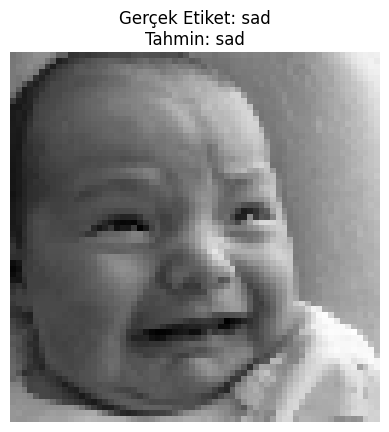

In [16]:
# %% Cell 10: Model Kaydetme, Yükleme ve Test Görselleştirme (Güncellenmiş)
import random
import joblib
import matplotlib.pyplot as plt

# Kaydedilen SVM modelini yükleyelim
best_model = joblib.load("best_svm_model.pkl")
# Kaydedilen PCA nesnesini de yükleyelim
pca = joblib.load("pca_transformer.pkl")

# Aynı özellik çıkarımında kullandığınız CNN modelini yeniden oluşturun
cnn_extractor = DeepCNNFeatureExtractor().to(device)
cnn_extractor.eval()

# Validation dataset'inden rastgele bir örnek seçelim
idx = random.randint(0, len(val_dataset) - 1)
img_tensor, original_image, true_label = val_dataset[idx]

# Hibrit özellikleri çıkaralım (CNN, HOG, LPG)
hybrid_feat = extract_hybrid_features(img_tensor, cnn_extractor, original_image)  # Boyut: 2056
# PCA dönüşümünü uygulayalım: 2056 -> 500
X_sample = pca.transform(hybrid_feat.reshape(1, -1))

# SVM modeli ile tahmin yapalım
predicted_label = best_model.predict(X_sample)[0]

# Sonuçları görselleştirme
plt.imshow(original_image, cmap="gray")
plt.title(f"Gerçek Etiket: {classes[true_label]}\nTahmin: {classes[predicted_label]}")
plt.axis("off")
plt.show()
